# Problem Statement

Differentiate between subreddit posts more commonly associated with confessions or relationships.

## Importing Libraries

In [1]:
import numpy as np
import requests
import pandas as pd
import time
import random
import regex as re

import matplotlib.pyplot as plt

from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize

from sklearn.metrics import classification_report, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import  KNeighborsClassifier 

import warnings
from psaw import PushshiftAPI

# After the imports
warnings.filterwarnings(action='ignore')

# Data Acquisition

In [ ]:
urls = {'confessions' : 'https://www.reddit.com/r/confessions.json', 
        'relationships' : 'https://www.reddit.com/r/relationships.json'}

Scrap data using the PushShiftAPI to extract more than 1000 posts per subreddit to overcome Reddit's imposed limitation.

In [ ]:
%time

api = PushshiftAPI()
confessions = pd.DataFrame(list(api.search_submissions(subreddit='confessions',
                                         filter=['author','title','subreddit','selftext'],
                                         limit=3000)))
relationships = pd.DataFrame(list(api.search_submissions(subreddit='relationships',
                                         filter=['author','title','subreddit','selftext'],
                                         limit=3000)))

# store the scrapped data.
confessions.to_csv('./data/confessions.csv')
relationships.to_csv('./data/relationships.csv')

In [ ]:
# %time
## Scrapper using conventional methods
# def reddit_scrapper(key,url,n_iterations=10):
    
#     #load_previous_file
#     prev_posts = pd.read_csv('./data/' + str(key) + '.csv')
#     print("Number of records loaded : {}".format(prev_posts.shape[0]))
    
#     posts = []
#     after = None

#     for a in range(n_iterations):
#         if after == None:
#             current_url = url + '?limit=100'
#         else:
#             current_url = url + '?after=' + after + '&limit=100'
#         print(current_url)
#         res = requests.get(current_url, headers={'User-agent': 'Falcon 2.0'})

#         if res.status_code != 200:
#             print('Status error', res.status_code)
#             break

#         current_dict = res.json()
#         current_posts = [p['data'] for p in current_dict['data']['children']]
#         posts.extend(current_posts)
#         after = current_dict['data']['after']

#         # generate a random sleep duration to look more 'natural'
#         sleep_duration = random.randint(2,6)
        
#         time.sleep(sleep_duration)
    
#     #add_to_existing
#     posts = pd.DataFrame(posts)
#     posts_df = posts.append(prev_posts,ignore_index=True)
#     #remove duplicates
#     #posts_df.drop_duplicates(inplace=True)
#     print("Number of records stored : {}".format(posts_df.shape[0]))
#     posts_df.to_csv('./data/' + str(key) + '.csv', index = False)

### Load in Data

In [2]:
df_relationships = pd.read_csv('./data/relationships.csv')
df_confessions = pd.read_csv('./data/confessions.csv')

## Data Cleaning

We create a `filter_columns` function that filters out the title, self text and subreddit name (our target)

In [3]:
def filter_columns(df):
    columns_to_retain = ['title','selftext','subreddit','author']
    return df[columns_to_retain]

In [4]:
df_relationships_clean = filter_columns(df_relationships)
df_conf_clean = filter_columns(df_confessions)

In [5]:
display(df_relationships_clean.count())
display(df_conf_clean.count())

title        3000
selftext     2985
subreddit    3000
author       3000
dtype: int64

title        3000
selftext     2507
subreddit    3000
author       3000
dtype: int64

We can observe that the classes are imbalanced. For our classification dataset, we will aim to have a 1:1 class balance.

In [6]:
df_relationships_clean.head()

,title,selftext,subreddit,author
0,I (20F) don't know if I want to see my LDR(19M...,"I don't know if I want to see my LDR anymore, ...",relationships,another4ccount12345
1,What does this mean?,Ex got very pissed off and mad when I said tha...,relationships,horse126
2,Friend (22M) is dating my (22M) sister (20F). ...,My friend is dating my sister. At first I was ...,relationships,turndownforcat
3,Oof,[removed],relationships,kelsonyt
4,I unfairly compare everyone to my ex and I wis...,[removed],relationships,babelfiish


In [7]:
df_conf_clean.head()

,title,selftext,subreddit,author
0,I lost my virginity in a 3 way,Im a 19 year old male in a rural town. This ha...,confessions,jdallis
1,I blame myself,I’m a woman in my early 30s. I’m a lesbian and...,confessions,heynotyouagain
2,"I'm just realizing that I was assaulted, 7 yea...",I broke up with my ex-boyfriend because he was...,confessions,will0w27
3,I mistakenly sent an intimate video of my GF a...,"This is a long, long post. Full of an excessiv...",confessions,IamAFUkkingIdiot3
4,"I’m 16, and I’m going to court tomorrow.","Long story short, I got caught by the cops smo...",confessions,holygift462


Prior to this, we may wish to remove posts that have 'Moderator' as an author to train our model on more 'authentic' posts.

In [8]:
df_relationships_clean.loc[:,'author'] = df_relationships_clean.author.map(lambda x : x.lower())
df_conf_clean.loc[:,'author'] = df_conf_clean.author.map(lambda x : x.lower())

In [9]:
df_relationships_clean = df_relationships_clean[~df_relationships_clean.author.str.contains('moderator')]
df_conf_clean = df_conf_clean[~df_conf_clean.author.str.contains('moderator')]

In [10]:
df_relationships_clean.isna().sum()

title         0
selftext     15
subreddit     0
author        0
dtype: int64

In [11]:
df_conf_clean.isna().sum()

title          0
selftext     493
subreddit      0
author         0
dtype: int64

We also observe empty selftext in both subreddits. we shall drop rows with empty selftext.

In [12]:
df_relationships_clean = df_relationships_clean.dropna(axis=0)
df_conf_clean = df_conf_clean.dropna(axis=0)

Ensure only posts with selftext more than 10words are selected.

In [13]:
df_relationships_clean ['selftext_len'] = df_relationships_clean .selftext.map(lambda x: len(x.split()))
df_relationships_clean  = df_relationships_clean [df_relationships_clean .selftext_len > 10]
df_conf_clean['selftext_len'] = df_conf_clean.selftext.map(lambda x: len(x.split()))
df_conf_clean = df_conf_clean[df_conf_clean.selftext_len > 10]

In [14]:
df_relationships_clean.drop_duplicates(inplace=True)
df_conf_clean.drop_duplicates(inplace=True)

In [15]:
display(df_relationships_clean.count())
display(df_conf_clean.count())

title           1801
selftext        1801
subreddit       1801
author          1801
selftext_len    1801
dtype: int64

title           2286
selftext        2286
subreddit       2286
author          2286
selftext_len    2286
dtype: int64

In [16]:
# check posts with [deleted] or [removed]
print("[deleted] Counts:")
display((df_relationships_clean.title == '[deleted]').value_counts())
display((df_conf_clean.title == '[deleted]').value_counts())
print("[removed] Counts:")
display((df_relationships_clean.title == '[removed]').value_counts())
display((df_conf_clean.title == '[removed]').value_counts())

[deleted] Counts:


False    1801
Name: title, dtype: int64

False    2286
Name: title, dtype: int64

[removed] Counts:


False    1801
Name: title, dtype: int64

False    2286
Name: title, dtype: int64

We will then randomly select 1800 of each class since quite a significant number were from a moderator-author as well as empty text.

In [17]:
subset_relationships_clean = df_relationships_clean.sample(n=1800,random_state=666)
subset_conf_clean = df_conf_clean.sample(n=1800,random_state=666)

In [18]:
# combine both subsets into a DF
df_pre = subset_relationships_clean.append(subset_conf_clean,ignore_index=True)
df_pre.subreddit.value_counts()

relationships    1800
confessions      1800
Name: subreddit, dtype: int64

In [24]:
# create target class columns 0 = relationships, 1 = confessions 

df_pre['label'] = df_pre.subreddit.map({'relationships':0,'confessions':1}).astype('int')
df_pre.head()

,title,selftext,subreddit,author,selftext_len,label
0,I (23F) can't stand my toxic boyfriend (24M) w...,I've been dating my boyfriend for about 3.5 ye...,relationships,faultless_to_a_fault,421,0
1,I [24m] knocked up my girlfriend [22f] of nine...,"As the title says, I've been with my girlfrien...",relationships,substantial_program,305,0
2,My BFF (17/F) keeps lying and breaks my (15/F)...,This is a teens argument so i apologise\n in a...,relationships,stalinesexslave2,484,0
3,"I (M,40) absolutely adore my partner (F,39) bu...",I’m a m of 40 and my partner is 39. We have be...,relationships,iam_mrgee,367,0
4,My Boyfriend (25m) Called me (28f) Fat Ass.,I dont want to make this a long post so I'm go...,relationships,smellslikecheerios,310,0


Ensure formatting of text by:
- Converting all to lower cases
- removing groups of words in parantheses
- remove line breaks
- removing special characters


In [25]:
# convert the stop words to a set.
stops = set(stopwords.words('english'))

def clean_text(text):
    #01 convert titles, selftext into lowercase
    lower_text = text.lower()
    #02 remove brackets and parenthesis from the title and selftext.
    no_br_paret_text = re.sub(r'\(.+?\)|\[.+?\]',' ',str(lower_text))
    #03 remove special characters
    removed_special = re.sub(r'[^0-9a-zA-Z ]+',' ',str(no_br_paret_text))
    #04 remove xamp200b
    remove_xamp200b = re.sub(r'ampx200b',' ',str(removed_special))
    #05 remove digits
    result = re.sub(r'\d+', '', remove_xamp200b).split()
    #06 split into individual words
    meaningful_words = [w for w in result if not w in stops]
    
    #07 Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))


In [26]:
df_pre[['title','selftext']] = df_pre[['title','selftext']].applymap(clean_text)
df = df_pre.copy()
df.head()

,title,selftext,subreddit,author,selftext_len,label
0,stand toxic boyfriend game together stop ruini...,dating boyfriend years rough patches pretty go...,relationships,faultless_to_a_fault,421,0
1,knocked girlfriend nine months terrible idea g...,title says girlfriend nine months going really...,relationships,substantial_program,305,0
2,bff keeps lying breaks heart talk help,teens argument apologise advance long boring e...,relationships,stalinesexslave2,484,0
3,absolutely adore partner feel like interested ...,partner together years two children youngest y...,relationships,iam_mrgee,367,0
4,boyfriend called fat ass,dont want make long post going try make easy r...,relationships,smellslikecheerios,310,0


In [27]:
pd.DataFrame(data=zip(df_pre['selftext'],df['selftext']),columns=['pre','post']).head(5)

,pre,post
0,dating boyfriend years rough patches pretty go...,dating boyfriend years rough patches pretty go...
1,title says girlfriend nine months going really...,title says girlfriend nine months going really...
2,teens argument apologise advance long boring e...,teens argument apologise advance long boring e...
3,partner together years two children youngest y...,partner together years two children youngest y...
4,dont want make long post going try make easy r...,dont want make long post going try make easy r...


## Data Exploration

Split title and self text into two classifiers where the output of title_classifier and self_text classifier would provide indication of subreddit belonging.

In [28]:
#split titles, and self text into seperate df

df_title = df[['title','label']]
df_selftext = df[['selftext','label']]

In [30]:
def get_freq_words(sparse_counts, columns):
    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting
    word_counts = np.asarray(sparse_counts.sum(axis=0)).reshape(-1)

    # argsort() returns smallest first, so we reverse the result
    largest_count_indices = word_counts.argsort()[::-1]

    # pretty-print the results! Remember to always ask whether they make sense ...
    freq_words = pd.Series(word_counts[largest_count_indices], 
                           index=columns[largest_count_indices])

    return freq_words

In [32]:
# Let's use the CountVectorizer to count words for us for each class

# create mask

X_1 = df_selftext[df_selftext['label'] == 1]
X_0 = df_selftext[df_selftext['label'] == 0]

cvt      =  CountVectorizer(ngram_range=(1,1),stop_words='english')
X_1_all    =  cvt.fit_transform(X_1['selftext'])
X_0_all    =  cvt.fit_transform(X_0['selftext'])
columns_1  =  np.array(cvt.get_feature_names())          # ndarray (for indexing below)
columns_0  =  np.array(cvt.get_feature_names())    

In [33]:
freq_words_1 = get_freq_words(X_1_all, columns_1)
freq_words_0 = get_freq_words(X_0_all, columns_0)
print('Confessions:')
display(freq_words_1[:10])
print('Relationships:')
display(freq_words_0[:10])

Confessions:


landed           1870
jaunt            1272
fallacies        1035
tactics          1025
unreal            951
psychological     903
owe               840
genre             699
laconically       680
sushi             659
dtype: int64

Relationships:


like            4112
time            3048
know            2949
want            2740
feel            2528
really          2485
relationship    2314
said            2122
things          1960
told            1888
dtype: int64

### Split selftext 

In [34]:
X_text = df_selftext['selftext']
y_text = df_selftext['label']

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text,y_text,stratify=y_text) 

# Data Modeling

In [35]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

Use Naive Bayers model - MultinomialNB as there are multiple nominal features in the form of the various tokens.

In [36]:
classifiers = []
vectorizers = [('cvec', CountVectorizer(stop_words='english',tokenizer=LemmaTokenizer())),
              ('tfvec', TfidfVectorizer(stop_words='english',tokenizer=LemmaTokenizer()))]

for vectorizer in vectorizers:
    bayes_pipe = Pipeline([
            (vectorizer),
            ('mnb', MultinomialNB())
        ])
    scores = cross_val_score(bayes_pipe, X_text_train, y_text_train,cv=5,verbose=1)
    b = bayes_pipe.fit(X_text_train, y_text_train)
    y_pred = b.predict(X_text_test)
    print(classification_report(y_text_test, y_pred, target_names=['class 0','class 1']))
    print('Cross val score for mnb classifier using {} vectorizer is {}'.format(vectorizer[0],scores))
    print('Accuracy score for mnb classifier using {} vectorizer is {}'.format(vectorizer[0],bayes_pipe.score(X_text_test, y_text_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.3s finished


              precision    recall  f1-score   support

     class 0       0.73      0.95      0.82       450
     class 1       0.93      0.64      0.76       450

    accuracy                           0.80       900
   macro avg       0.83      0.80      0.79       900
weighted avg       0.83      0.80      0.79       900

Cross val score for mnb classifier using cvec vectorizer is [0.80185185 0.81851852 0.80185185 0.79259259 0.82962963]
Accuracy score for mnb classifier using cvec vectorizer is 0.7955555555555556


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.6s finished


              precision    recall  f1-score   support

     class 0       0.61      0.99      0.76       450
     class 1       0.98      0.38      0.55       450

    accuracy                           0.69       900
   macro avg       0.80      0.69      0.65       900
weighted avg       0.80      0.69      0.65       900

Cross val score for mnb classifier using tfvec vectorizer is [0.71111111 0.68703704 0.66666667 0.69814815 0.7037037 ]
Accuracy score for mnb classifier using tfvec vectorizer is 0.6855555555555556


Thus the recall scores for multonomial NB with countvectorizer seems to provide higher recall when compared to the tfidf vectorizer.

In [40]:
# store predicted_proba scores for later evaluation under ROC curve
def generate_roc(pipeline):

    b = pipeline.fit(X_text_train, y_text_train)
    fpr, tpr, _ = roc_curve(y_text_test, b.predict_proba(X_text_test)[:,1],pos_label=1)
    
    return [fpr,tpr]


In [42]:
cv_bayes_pipe = Pipeline([
            (vectorizers[0]),
            ('mnb', MultinomialNB())
        ])

cv_nb_roc = generate_roc(cv_bayes_pipe)


In [46]:
tfidf_bayes_pipe = Pipeline([
            (vectorizers[1]),
            ('mnb', MultinomialNB())
        ])

tfidf_nb_roc = generate_roc(tfidf_bayes_pipe)

## Pipeline for Logistic Regression

In [47]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english',tokenizer=LemmaTokenizer())),
    ('lr', LogisticRegression(solver='saga',max_iter=300))
])

#### Obtain hyperparameters for our vectorizer and logistic regressor.

In [ ]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty' : ['elasticnet'],
    'lr__C' : np.arange(0.1,1,0.1),
    'lr__l1_ratio' : np.arange(0,1.1,0.2)
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5,verbose=1,n_jobs=-1)
gs.fit(X_text_train, y_text_train)
print(gs.best_score_)

In [ ]:
gs.best_params_

In [ ]:
gs.best_estimator_.score(X_text_test,y_text_test)

In [48]:
# try model on title
optimal_pipe = Pipeline([
            ('cvec', CountVectorizer(tokenizer=LemmaTokenizer(),max_features=3500,ngram_range=(1,1))),
            ('lr', LogisticRegression(solver='saga',max_iter=300,C=0.1,l1_ratio=0.0,penalty='elasticnet'))
        ])

In [49]:
X_title = df_title['title']
y_title = df_title['label']

In [50]:
optimal_pipe.fit(X_text_train, y_text_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=3500, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x1204e6400>,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=0.0, max_iter=300,
                     

We try the model on our `title` dataset to obtain the accuracy of the model to classify the subreddit from titles alone.

In [51]:
cv_log_roc = generate_roc(optimal_pipe)

In [52]:
y_logr_pred = optimal_pipe.predict(X_text_test)
print(classification_report(y_text_test, y_logr_pred, target_names=['class 0','class 1']))

              precision    recall  f1-score   support

     class 0       0.81      0.94      0.87       450
     class 1       0.93      0.78      0.85       450

    accuracy                           0.86       900
   macro avg       0.87      0.86      0.86       900
weighted avg       0.87      0.86      0.86       900



Next, we explore the use tfidfvectorizer instead of countvectorizer to account for document similarity

In [ ]:
tfidf_pipe = Pipeline([
    ('tfvec', TfidfVectorizer(stop_words='english',tokenizer=LemmaTokenizer())),
    ('lr', LogisticRegression(solver='saga',max_iter=300))
])

tfidf_params = {
    'tfvec__max_features': [2500, 3000, 3500],
    'tfvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty' : ['elasticnet'],
    'lr__C' : np.arange(0.1,1,0.1),
    'lr__l1_ratio' : np.arange(0,1.1,0.2)
}

gs = GridSearchCV(tfidf_pipe, param_grid=tfidf_params, cv=3,verbose=1,n_jobs=-1)
gs.fit(X_text_train, y_text_train)
print(gs.best_score_)

It seems that tfidf vectorizer performs best with the logistic regression model.

In [ ]:
gs.best_params_

In [53]:
tfidf_best_pipe = Pipeline([
    ('tfvec', TfidfVectorizer(max_features=3500,ngram_range=(1,1),stop_words='english',tokenizer=LemmaTokenizer())),
    ('lr', LogisticRegression(solver='saga',max_iter=300,C=0.9,l1_ratio=1.0,penalty='elasticnet'))
])

In [54]:
tfidf_log_roc = generate_roc(tfidf_best_pipe)

In [55]:
# test model against test text data and rest of titles
y_text_tfidf_pred = gs.best_estimator_.predict(X_text_test)
y_title_tfidf_pred = gs.best_estimator_.predict(X_title)
print("Text Report (results based on test data) \n" + 
      classification_report(y_text_test, y_text_tfidf_pred, target_names=['class 0','class 1']))
print("Titles (all titles) Report \n" + 
      classification_report(y_title, y_title_tfidf_pred, target_names=['class 0','class 1']))

NameError: name 'gs' is not defined

While the optimised model with tfidf vectorizer performs remarkably well with high precision and recall, when used with the titles dataset, we can see that that it is somewhat overfit, unable to classify the titles correctly.

In [ ]:
# look at sample predictions

pd.DataFrame(data=zip(X_text_test,y_text_test,y_text_tfidf_pred),columns=['text','actual','predicted']).head(5)

In [ ]:
knn_pipe = Pipeline([
    ('tfvec', TfidfVectorizer(stop_words='english',tokenizer=LemmaTokenizer())),
    ('knn', KNeighborsClassifier())
])

knn_params = {
    'tfvec__max_features': [2500, 3000, 3500],
    'tfvec__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors' : np.arange(5,100,10),
    'knn__weights' : ['uniform','distance'],
    'knn__leaf_size': np.arange(10,30,10) 
}

In [ ]:
knn_gs = GridSearchCV(knn_pipe, param_grid=knn_params, cv=3,verbose=1,n_jobs=-1)
knn_gs.fit(X_text_train, y_text_train)

In [ ]:
knn_gs.best_params_

In [56]:
knn_best_pipe = Pipeline([
    ('tfvec', TfidfVectorizer(max_features=2500,ngram_range=(1,2),stop_words='english',tokenizer=LemmaTokenizer())),
    ('knn', KNeighborsClassifier(leaf_size=10,n_neighbors=15,weights='distance'))
])

In [57]:
tfidf_knn_roc = generate_roc(knn_best_pipe)

In [ ]:
# test model against test text data and rest of titles
y_text_knn_pred = knn_gs.best_estimator_.predict(X_text_test)
y_title_knn_pred = knn_gs.best_estimator_.predict(X_title)
print("Text Report (results based on test data) \n" + 
      classification_report(y_text_test, y_text_knn_pred, target_names=['class 0','class 1']))
print("Titles (all titles) Report \n" + 
      classification_report(y_title, y_title_knn_pred, target_names=['class 0','class 1']))

## Model Evaluation & Summary

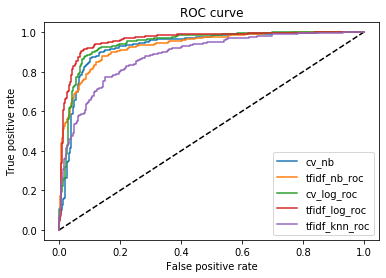

In [58]:
# Evaluation

roc_data ={
    'cv_nb' : cv_nb_roc,
    'tfidf_nb_roc' : tfidf_nb_roc,
    'cv_log_roc' : cv_log_roc,
    'tfidf_log_roc' : tfidf_log_roc,
    'tfidf_knn_roc' : tfidf_knn_roc
}

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
for key,roc in roc_data.items():
    plt.plot(roc[0], roc[1], label=key)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
